In [1]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import copy
import joblib
import shap
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score,  make_scorer, fbeta_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ParameterSampler

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Constants
lr = 5e-4
weight_decay = 1e-4
batch_size = 64
num_epochs = 75
num_runs = 2
max_patience = 13

# pd 
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0)

Using device: cuda


In [2]:
def load_datasets(base_path="./"):
    
    files = {"train": "cs-training.csv"}
    dfs = {}
    
    for key, filename in files.items():
        print(f"Loading {filename}...")
        dfs[key] = pd.read_csv(base_path + filename, index_col=0)
        print(f"Loaded {filename} with {len(dfs[key].columns)} columns")
        
    return dfs

def dataset_summary(df, y=None, threshold=0.7):
    
    df_copy = df.copy()

    if y is not None and y.name in df_copy.columns:
        df_copy = df_copy.drop(columns=[y.name])
    
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in cat_cols:
        df_copy[col] = df_copy[col].astype("category").cat.codes
        
    numeric_cols = df_copy.select_dtypes(include="number").columns
    imputed_flags = [col for col in numeric_cols if col.startswith("Was") or col.endswith("Imputed")]
    regular_numeric_cols = [col for col in numeric_cols if col not in imputed_flags]

    df_num = df_copy[regular_numeric_cols].copy()
    
    df_num.replace([np.inf, -np.inf], np.nan, inplace=True)

    print(f"Dataset shape: {df_num.shape}")
    print(f"Total rows: {len(df_num)}")
    print(f"Total duplicate rows: {df_num.duplicated().sum()}")

    desc = df_num.describe().T
    desc["skew"] = df_num.skew()
    
    desc["dtype"] = df_copy[desc.index].dtypes
    desc["non_null"] = df_copy[desc.index].notna().sum()
    desc["missing"] = df_copy[desc.index].isna().sum()
    desc["missing_%"] = (df_copy[desc.index].isna().mean() * 100).round(2)
    desc["unique"] = df_copy[desc.index].nunique()
    
    if y is not None:
        df_num['target'] = y
        desc["corr_with_target"] = df_num.corr()['target'].drop('target')
    
    corr_matrix = df_copy.corr(numeric_only=True)
       
    corr_pairs = (
        corr_matrix
        .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
    )
      
    high_corr = corr_pairs[abs(corr_pairs) > threshold]
     
    corr_map = {}
    for (f1, f2), val in high_corr.items():
        corr_map.setdefault(f1, []).append(f"{f2} ({val:.2f})")
        corr_map.setdefault(f2, []).append(f"{f1} ({val:.2f})")
    
    high_corr_flags = []
    high_corr_with = []
    
    for col in desc.index:
        if col in corr_map:
            high_corr_flags.append(True)
            high_corr_with.append(", ".join(corr_map[col]))
        else:
            high_corr_flags.append(False)
            high_corr_with.append("")
    
    desc["high_corr_flag"] = high_corr_flags
    desc["high_corr_with"] = high_corr_with
    
    return desc.sort_values("missing_%", ascending=False)

def outlier_handling(X, y, n_high=100, n_low=10):
    
    X_copy = X.copy()
    y_copy = y.copy()
    
    numeric_cols = X_copy.select_dtypes(include=["number"]).columns.tolist()
    X_copy[numeric_cols] = X_copy[numeric_cols].fillna(0)

    hgb = HistGradientBoostingClassifier(
        max_iter=100,
        random_state=42,
        min_samples_leaf=20
    )
    hgb.fit(X_copy, y_copy)
    y_pred_proba = hgb.predict_proba(X_copy)[:, 1]

    df_combined = X_copy.copy()
    df_combined["__pred_proba__"] = y_pred_proba
    df_combined["__target__"] = y_copy.values

    df_sorted = df_combined.sort_values("__pred_proba__", ascending=True).reset_index(drop=True)

    total_rows = len(df_sorted)
    start_idx = n_low
    end_idx = max(0, total_rows - n_high)

    df_filtered = df_sorted.iloc[start_idx:end_idx].reset_index(drop=True)

    dropped = total_rows - len(df_filtered)
    print(f"Dropped {dropped} outlier rows (lowest {n_low}, highest {n_high})")

    X_filtered = df_filtered.drop(columns=["__pred_proba__", "__target__"])
    y_filtered = df_filtered["__target__"]

    return X_filtered, y_filtered

def drop_target_and_ids(df):
    
    df_copy = df.copy()
    
    feature_cols_to_drop = ["SeriousDlqin2yrs"]
    target = df_copy["SeriousDlqin2yrs"]
    df_raw_features = df_copy.drop(columns=feature_cols_to_drop)
    
    print(f"Dropped cols: {feature_cols_to_drop}")
    
    return df_raw_features, target, feature_cols_to_drop

def drop_high_missing_cols(df, threshold=0.3):

    missing_frac = df.isna().mean().sort_values(ascending=False)
    missing_summary = pd.DataFrame({
        'MissingCount': df.isna().sum(),
        'MissingPercent': (missing_frac * 100).round(2)
    })

    if df.isna().sum().sum() > 0:
        print(missing_summary.to_string())
    
    hm_cols_to_drop = missing_frac[missing_frac > threshold].index.tolist()
    
    if hm_cols_to_drop:
        df_drop = df.drop(columns=hm_cols_to_drop)
        print(f"Dropped: {len(hm_cols_to_drop)} high missing cols")
        print(f"Dropped cols: {hm_cols_to_drop}")
    else:
        df_drop = df.copy()
        print("No high missing cols dropped")
        
    return df_drop, hm_cols_to_drop

def drop_high_card_cols(df, threshold=50):

    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    unique_counts = df[cat_cols].nunique().sort_values(ascending=False)
    unique_summary = pd.DataFrame({
        'UniqueCount': unique_counts,
        'UniquePercent': (unique_counts / len(df) * 100).round(2)
    })

    if cat_cols:
        print(unique_summary.to_string())

    hc_cols_to_drop = unique_counts[unique_counts > threshold].index.tolist()

    if hc_cols_to_drop:
        df_high = df.drop(columns=hc_cols_to_drop, errors='ignore')
        print(f"Dropped: {len(hc_cols_to_drop)} high cardinality cols")
        print(f"Dropped cols: {hc_cols_to_drop}")
    else:
        df_high = df.copy()
        print("No high cardinality cols dropped")

    return df_high, hc_cols_to_drop

def collapse_rare_categories(df, threshold=0.005):
    
    df_copy = df.copy()
    
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    
    rare_maps = {}

    for col in cat_cols:
        freqs = df_copy[col].value_counts(normalize=True, dropna=True)
        rare_cats = [c for c in freqs[freqs < threshold].index]
        if rare_cats:
            df_copy[col] = df_copy[col].astype('object').replace(rare_cats, 'Other')
            rare_maps[col] = set(rare_cats)
            print(f"Column '{col}': collapsed {len(rare_cats)} rare categories: {rare_cats}")
        else:
            print(f"Column '{col}': no rare categories to collapse")

    return df_copy, rare_maps

def select_features(df, target, n_to_keep=10):
    
    df_temp = df.copy()
    
    cat_cols = df_temp.select_dtypes(include=["object", "category"]).columns.tolist()
    df_model = df_temp.copy()
    for col in cat_cols:
        df_model[col] = df_model[col].astype("category").cat.codes

    feature_cols = df_model.columns.tolist()

    X_train, _, y_train, _ = train_test_split(
        df_model[feature_cols],
        target,
        test_size=0.2,
        random_state=42,
        stratify=target,
    )

    X_train = X_train.astype(np.float32)

    best_param = {
        "learning_rate": 0.3,
        "max_depth": 6,
        "min_child_weight": 1,
        "gamma": 0,
        "subsample": 1.0,
        "colsample_bytree": 1.0,
        "reg_alpha": 0,
        "reg_lambda": 1
    }

    model = xgb.XGBClassifier(
        **best_param,
        objective="binary:logistic",
        eval_metric="auc",
        scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
        n_estimators=800,
        max_bin=1024,
        booster="gbtree",
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        device="cuda",
    )
    
    model.fit(X_train, y_train, verbose=False)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    
    importance_df = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": mean_abs_shap
    }).sort_values("Importance", ascending=False).reset_index(drop=True)

    top_features = importance_df["Feature"].head(n_to_keep).tolist()

    final_features = list(set(top_features + cat_cols))

    dropped_features = [f for f in df_temp.columns if f not in final_features]

    print(f"Kept {len(final_features)} features (including categorical columns)")
    print(f"Dropped {len(dropped_features)} features")
    if dropped_features:
        print(f"Dropped cols: {dropped_features}")
    print(importance_df)

    return df_temp[final_features].copy(), dropped_features

def impute_and_scale(df):
    
    df_copy = df.copy()
    
    num_imputer = None
    robust_scaler = None
    std_scaler = None
    cat_imputer=None
    cat_maps = {}
    skewed_cols = []

    num_col_order = df_copy.select_dtypes(include=['number']).columns.tolist()
    cat_col_order = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()

    if num_col_order:
        df_copy[num_col_order] = df_copy[num_col_order].replace([np.inf, -np.inf], np.nan)
        for col in num_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        num_imputer = SimpleImputer(strategy='median')
        df_copy[num_col_order] = num_imputer.fit_transform(df_copy[num_col_order])
        skewness = df_copy[num_col_order].skew().sort_values(ascending=False)
        skewed_cols = skewness[abs(skewness) > 1.0].index.tolist()
        normal_cols = [c for c in num_col_order if c not in skewed_cols]
        if skewed_cols:
            robust_scaler = RobustScaler()
            df_copy[skewed_cols] = robust_scaler.fit_transform(df_copy[skewed_cols])
        if normal_cols:
            std_scaler = StandardScaler()
            df_copy[normal_cols] = std_scaler.fit_transform(df_copy[normal_cols])

    if cat_col_order:
        df_copy[cat_col_order] = df_copy[cat_col_order].astype('object') 
        for col in cat_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df_copy[cat_col_order] = cat_imputer.fit_transform(df_copy[cat_col_order]) 
        for col in cat_col_order:
            unique_cats = df_copy[col].astype(str).unique()
            cat_maps[col] = {cat: idx for idx, cat in enumerate(unique_cats)}

    imputed_flags = [col for col in df_copy.columns if col.startswith("Was") and col.endswith("Imputed")]

    print("Imputed, flagged, and scaled features")
    
    return df_copy, num_imputer, cat_imputer, robust_scaler, std_scaler, num_col_order, skewed_cols, cat_col_order, cat_maps, imputed_flags

def transform_val_test(
    df, 
    cols_to_drop=None, 
    num_imputer=None,
    cat_imputer=None,
    robust_scaler=None, 
    std_scaler=None,
    num_col_order=None, 
    skewed_cols=None,
    cat_col_order=None,
    rare_maps=None,
    train_columns=None
):
    
    df_copy = df.copy()

    if cols_to_drop:
        df_copy = df_copy.drop(columns=cols_to_drop, errors='ignore')

    if num_col_order:     
        df_copy[num_col_order] = df_copy[num_col_order].replace([np.inf, -np.inf], np.nan)
        for col in num_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        df_copy[num_col_order] = num_imputer.transform(df_copy[num_col_order])
        skewed_cols = skewed_cols or []
        normal_cols = [c for c in num_col_order if c not in skewed_cols]
        if skewed_cols and robust_scaler:
            df_copy[skewed_cols] = robust_scaler.transform(df_copy[skewed_cols])
        if normal_cols and std_scaler:
            df_copy[normal_cols] = std_scaler.transform(df_copy[normal_cols])
            
    if cat_col_order:
        df_copy[cat_col_order] = df_copy[cat_col_order].astype('object')
        for col in cat_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        for col in cat_col_order:
            if rare_maps and col in rare_maps:
                rare_categories = list(rare_maps[col])
                df_copy[col] = df_copy[col].replace(rare_categories, 'Other')
        df_copy[cat_col_order] = cat_imputer.transform(df_copy[cat_col_order])
   
    if train_columns is not None:
        df_copy = df_copy.reindex(columns=train_columns, fill_value=0)

    imputed_flags = [col for col in df_copy.columns if col.startswith("Was") and col.endswith("Imputed")]

    print("Imputed, flagged, and scaled features")
    
    return df_copy, imputed_flags

def check_and_drop_duplicates(df, target=None):
    
    df_cleaned = df.drop_duplicates()
    
    count = df.duplicated().sum()

    if target is None:
        print(f"Dropped: {count} duplicates")
        return df_cleaned

    target_cleaned = pd.Series(target).reindex(df_cleaned.index)
    mask = target_cleaned.notna()
    df_cleaned = df_cleaned[mask].reset_index(drop=True)
    target_cleaned = target_cleaned[mask].reset_index(drop=True)

    print(f"Dropped: {count} duplicates")
    
    return df_cleaned, target_cleaned

def threshold_by_target_recall(y_true, y_probs, thresholds, target_recall):
    
    y_true = np.asarray(y_true).astype(int)
    y_probs = np.asarray(y_probs).astype(float)
    thresholds = np.asarray(thresholds).astype(float)

    preds = y_probs[:, None] > thresholds[None, :]
    TP = (preds & (y_true[:, None] == 1)).sum(axis=0)
    FN = ((~preds) & (y_true[:, None] == 1)).sum(axis=0)

    recall = TP / (TP + FN + 1e-8)
    closest_idx = np.argmin(np.abs(recall - target_recall))
    
    return thresholds[closest_idx]

In [3]:
def engineer_features(df):
    
    df_e = df.copy()

    NumberOfTime3059DaysPastDueNotWorse = df_e["NumberOfTime30-59DaysPastDueNotWorse"].fillna(0).clip(upper=10)
    NumberOfTimes90DaysLate = df_e["NumberOfTimes90DaysLate"].fillna(0).clip(upper=10)
    NumberOfTime6089DaysPastDueNotWorse = df_e["NumberOfTime60-89DaysPastDueNotWorse"].fillna(0).clip(upper=10)

    TotalPastDue = (
        NumberOfTime3059DaysPastDueNotWorse
        + NumberOfTimes90DaysLate
        + NumberOfTime6089DaysPastDueNotWorse
    )
    
    TotalPastDueLog = np.log1p(TotalPastDue)
    
    RevolvingUtilizationCapped = df_e["RevolvingUtilizationOfUnsecuredLines"].clip(upper=5.0)
    RevolvingUtilizationFilled = RevolvingUtilizationCapped.fillna(0)
    RevolvingUtilizationCappedLog = np.log1p(RevolvingUtilizationFilled)
    RevolvingUtilizationCappedLogSafe = RevolvingUtilizationCappedLog.replace(0, np.nan)
        
    AgeSafe = df_e["age"].replace(0, np.nan)

    DebtRatioCapped = df_e["DebtRatio"].fillna(0).clip(upper=10000.0)
        
    DebtRatioCappedLog = np.log1p(DebtRatioCapped)
    
    DebtRatioSafe =  DebtRatioCappedLog.replace(0, np.nan)

    MonthlyIncomeLog = np.log1p(df_e["MonthlyIncome"].fillna(0))

    MonthlyIncomeSafe = MonthlyIncomeLog.replace(0, np.nan)

    CreditLinesSafe = df_e["NumberOfOpenCreditLinesAndLoans"].replace(0, np.nan)

    NumberRealEstateLoansOrLinesfilled = df_e["NumberRealEstateLoansOrLines"].fillna(0)

    DebtToIncome = DebtRatioSafe * MonthlyIncomeSafe
    
    IncomePerCreditLine = MonthlyIncomeSafe / CreditLinesSafe

    AgeRisk = np.where(AgeSafe < 25, 1.0,
                 np.where(AgeSafe < 35, 0.8,
                 np.where(AgeSafe < 50, 0.6, 0.4)))

    DelinquencyScore = (
        NumberOfTime3059DaysPastDueNotWorse +
        NumberOfTime6089DaysPastDueNotWorse * 2 +
        NumberOfTimes90DaysLate * 3
    )

    DelinquencyScoreLog = np.log1p(DelinquencyScore)
    
    UtilizationPerAge = RevolvingUtilizationCappedLogSafe / AgeSafe

    DebtToIncomeAgeRisk = DebtToIncome * AgeRisk

    df_e["DebtRatio"] = DebtRatioSafe
    df_e["MonthlyIncomeSafe"] = MonthlyIncomeSafe 
    df_e["RevolvingUtilization"] = RevolvingUtilizationCappedLogSafe

    df_e["DelinquencyScore"] = DelinquencyScoreLog

    df_e["DelinquencyScoreUtilizationPerAge"] = DelinquencyScoreLog * UtilizationPerAge
    df_e["DelinquencyScoreRevolvingUtilization"] = DelinquencyScoreLog * RevolvingUtilizationCappedLogSafe

    df_e["UtilizationPerAge"] = UtilizationPerAge
    df_e["UtilizationPerCreditLine"] = RevolvingUtilizationCappedLogSafe / CreditLinesSafe
    df_e["LatePaymentsPerCreditLine"] = TotalPastDueLog / CreditLinesSafe 

    df_e["RealEstateLeverage"] = NumberRealEstateLoansOrLinesfilled * RevolvingUtilizationCappedLogSafe
    
    df_e["IncomePerCreditLine"] = IncomePerCreditLine
    df_e["DebtToIncomeAgeRisk"] = DebtToIncomeAgeRisk
    df_e["DebtToIncomeAgeRiskRevolvingUtilization"] = DebtToIncomeAgeRisk * RevolvingUtilizationCappedLogSafe
    
    df_e["IncomePerCreditLineAgeRisk"] = IncomePerCreditLine * AgeRisk 
    df_e["RevolvingUtilizationAgeRisk"] = RevolvingUtilizationCappedLogSafe * AgeRisk 

    Utilization_bins = [-0.01, 0.1, 0.3, 0.6, 0.9, 1.5, 10]
    Utilization_labels = ["Very Low", "Low", "Moderate", "High", "Very High", "Extreme"]
    UtilizationBucket = pd.cut(RevolvingUtilizationFilled, bins=Utilization_bins, labels=Utilization_labels)

    Late_bins = [-1, 0, 1, 3, 6, np.inf]
    Late_labels = ["NoLate", "FewLate", "ModerateLate", "FrequentLate", "ChronicLate"]
    LatePaymentBucket = pd.cut(TotalPastDueLog, bins=Late_bins, labels=Late_labels)

    df_e["UtilizationBucketLateBucket"] = (
        UtilizationBucket.astype(str) + "_" + LatePaymentBucket.astype(str)
    )

    engineered_cols = [
        "DebtRatio",
        "RevolvingUtilization",
        "MonthlyIncomeSafe",
        "DelinquencyScoreUtilizationPerAge",
        "DelinquencyScoreRevolvingUtilization",
        "DelinquencyScore",
        "RealEstateLeverage",
        "UtilizationPerAge",
        "IncomePerCreditLine",
        "LatePaymentsPerCreditLine",
        "DebtToIncomeAgeRisk",
        "UtilizationBucketLateBucket",
        "UtilizationPerCreditLine",
        "DebtToIncomeAgeRiskRevolvingUtilization",
        "IncomePerCreditLineAgeRisk",
        "RevolvingUtilizationAgeRisk",
    ]

    engineered_df = df_e[engineered_cols]

    print(f"Engineered {len(engineered_df)} features")
    print(f"Engineered cols: {list(engineered_df.columns)}")

    return engineered_df

In [4]:
# Load datasets
dfs = load_datasets()
df_train = dfs["train"]

Loading cs-training.csv...
Loaded cs-training.csv with 11 columns


In [5]:
# Summary
dataset_summary(df_train, df_train["SeriousDlqin2yrs"])

Dataset shape: (150000, 10)
Total rows: 150000
Total duplicate rows: 646


,count,mean,std,min,25%,50%,75%,max,skew,dtype,non_null,missing,missing_%,unique,corr_with_target,high_corr_flag,high_corr_with
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0,114.040318,float64,120269,29731,19.82,13594,-0.019746,False,
NumberOfDependents,146076.0,0.757222,1.115086,0.0,0.000000,0.000000,1.000000,20.0,1.588242,float64,146076,3924,2.62,13,0.046048,False,
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0,0.188995,int64,150000,0,0.00,86,-0.115386,False,
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0,97.631574,float64,150000,0,0.00,125728,-0.001802,False,
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0,95.157793,float64,150000,0,0.00,114194,-0.007602,False,
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0,22.597108,int64,150000,0,0.00,16,0.125587,True,"NumberOfTime60-89DaysPastDueNotWorse (0.99), NumberOfTimes90DaysLate (0.98)"
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0,1.215314,int64,150000,0,0.00,58,-0.029669,False,
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0,23.087345,int64,150000,0,0.00,19,0.117175,True,"NumberOfTime60-89DaysPastDueNotWorse (0.99), NumberOfTime30-59DaysPastDueNotWorse (0.98)"
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0,3.482484,int64,150000,0,0.00,28,-0.007038,False,
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0,23.331743,int64,150000,0,0.00,13,0.102261,True,"NumberOfTimes90DaysLate (0.99), NumberOfTime30-59DaysPastDueNotWorse (0.99)"


In [6]:
# Outlier Handling Manual
numeric_df = df_train.select_dtypes(include=['number'])

df_train = df_train[df_train['age'] > 0].reset_index(drop=True) 

df_train = df_train.sort_values(by="MonthlyIncome", ascending=False).iloc[1:].reset_index(drop=True) 

df_train = df_train[df_train['age'] > 0].reset_index(drop=True)

df_train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149998.000000,149998.000000,149998.000000,149998.000000,149998.000000,1.202670e+05,149998.000000,149998.000000,149998.000000,149998.000000,146074.000000
mean,0.066841,6.048512,52.295557,0.421032,353.009780,6.645265e+03,8.452766,0.265977,1.018234,0.240390,0.757198
std,0.249747,249.757035,14.771347,4.192809,2037.831702,1.148842e+04,5.145980,4.169331,1.129776,4.155207,1.115074
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029869,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559044,63.000000,0.000000,0.868260,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,1.794060e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [7]:
# Select targets
df_features, target, feature_cols_to_drop = drop_target_and_ids(df_train)
print(target.value_counts())

Dropped cols: ['SeriousDlqin2yrs']
SeriousDlqin2yrs
0    139972
1     10026
Name: count, dtype: int64


In [8]:
original_cols = df_features.select_dtypes(include=['number']).columns.tolist()
print(original_cols)

['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


In [9]:
# Split train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df_features, target, test_size=0.2, stratify=target, random_state=42
)

# Outlier Handling 
X_train_cut, y_train_cut = outlier_handling(
    X_train_full,
    y_train_full,
    n_high=130, 
    n_low=30
)

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_cut, y_train_cut, test_size=0.2, stratify=y_train_cut, random_state=42
)

Dropped 160 outlier rows (lowest 30, highest 130)


In [10]:
# Drop duplicates
X_train, y_train = check_and_drop_duplicates(X_train, y_train)
X_val, y_val = check_and_drop_duplicates(X_val, y_val)

Dropped: 451 duplicates
Dropped: 45 duplicates


In [11]:
# Engineer_features
df_e = engineer_features(X_train)

Engineered 95419 features
Engineered cols: ['DebtRatio', 'RevolvingUtilization', 'MonthlyIncomeSafe', 'DelinquencyScoreUtilizationPerAge', 'DelinquencyScoreRevolvingUtilization', 'DelinquencyScore', 'RealEstateLeverage', 'UtilizationPerAge', 'IncomePerCreditLine', 'LatePaymentsPerCreditLine', 'DebtToIncomeAgeRisk', 'UtilizationBucketLateBucket', 'UtilizationPerCreditLine', 'DebtToIncomeAgeRiskRevolvingUtilization', 'IncomePerCreditLineAgeRisk', 'RevolvingUtilizationAgeRisk']


In [12]:
df_e, y_train = check_and_drop_duplicates(df_e, y_train)

Dropped: 671 duplicates


In [13]:
# Drop columns with missing
df_drop, hm_cols_to_drop = drop_high_missing_cols(df_e, threshold=0.25)

                                         MissingCount  MissingPercent
DebtRatio                                        1789            1.89
DebtToIncomeAgeRisk                             20371           21.50
DebtToIncomeAgeRiskRevolvingUtilization         24610           25.97
DelinquencyScore                                    0            0.00
DelinquencyScoreRevolvingUtilization             6080            6.42
DelinquencyScoreUtilizationPerAge                6080            6.42
IncomePerCreditLine                             19642           20.73
IncomePerCreditLineAgeRisk                      19642           20.73
LatePaymentsPerCreditLine                        1034            1.09
MonthlyIncomeSafe                               18941           19.99
RealEstateLeverage                               6080            6.42
RevolvingUtilization                             6080            6.42
RevolvingUtilizationAgeRisk                      6080            6.42
UtilizationBucketLat

In [14]:
# Drop high card
df_high, hc_cols_to_drop = drop_high_card_cols(df_drop, threshold=50)

                             UniqueCount  UniquePercent
UtilizationBucketLateBucket           19           0.02
No high cardinality cols dropped


In [15]:
# Collapse rare categories
df_collapsed, rare_maps = collapse_rare_categories(df_high, threshold=0.05)

Column 'UtilizationBucketLateBucket': collapsed 14 rare categories: ['Very High_ModerateLate', 'Very Low_FewLate', 'Very High_FewLate', 'Low_FewLate', 'Moderate_FewLate', 'High_FewLate', 'High_ModerateLate', 'Moderate_ModerateLate', 'Very Low_ModerateLate', 'Low_ModerateLate', 'Extreme_NoLate', 'Extreme_ModerateLate', 'Very High_FrequentLate', 'Extreme_FewLate']


In [16]:
# Feature selection
df_selected, fs_cols_to_drop = select_features(df_collapsed, y_train, n_to_keep=17)

Kept 15 features (including categorical columns)
Dropped 0 features
                                 Feature  Importance
0                      UtilizationPerAge    1.083844
1               UtilizationPerCreditLine    0.629749
2                   RevolvingUtilization    0.605230
3                      MonthlyIncomeSafe    0.591682
4                    IncomePerCreditLine    0.581362
5              LatePaymentsPerCreditLine    0.556611
6                    DebtToIncomeAgeRisk    0.546711
7            RevolvingUtilizationAgeRisk    0.545548
8      DelinquencyScoreUtilizationPerAge    0.493025
9                              DebtRatio    0.484179
10            IncomePerCreditLineAgeRisk    0.438045
11                    RealEstateLeverage    0.326917
12                      DelinquencyScore    0.294342
13  DelinquencyScoreRevolvingUtilization    0.288357
14           UtilizationBucketLateBucket    0.231214


In [17]:
# Impute and scale
X_train, num_imputer, cat_imputer, robust_scaler, std_scaler, num_col_order, skewed_col_order, cat_col_order, cat_maps, X_train_flags = impute_and_scale(
    df_selected
)
print(num_col_order)
print(cat_col_order)
print(cat_maps)

Imputed, flagged, and scaled features
['DebtToIncomeAgeRisk', 'RealEstateLeverage', 'DelinquencyScoreRevolvingUtilization', 'DelinquencyScore', 'UtilizationPerAge', 'DebtRatio', 'IncomePerCreditLineAgeRisk', 'DelinquencyScoreUtilizationPerAge', 'IncomePerCreditLine', 'MonthlyIncomeSafe', 'RevolvingUtilizationAgeRisk', 'LatePaymentsPerCreditLine', 'UtilizationPerCreditLine', 'RevolvingUtilization']
['UtilizationBucketLateBucket']
{'UtilizationBucketLateBucket': {'Very Low_NoLate': 0, 'Low_NoLate': 1, 'Moderate_NoLate': 2, 'High_NoLate': 3, 'Other': 4, 'Very High_NoLate': 5}}


In [18]:
# Process
all_cols_to_drop = feature_cols_to_drop + hm_cols_to_drop + hc_cols_to_drop

X_val = engineer_features(X_val)
X_val, X_val_flags = transform_val_test(    
    X_val,
    all_cols_to_drop,
    num_imputer,
    cat_imputer,
    robust_scaler,
    std_scaler,
    num_col_order,
    skewed_col_order,
    cat_col_order,
    rare_maps,
    train_columns=X_train.columns,
)

X_test = engineer_features(X_test)
X_test, X_test_flags = transform_val_test(
    X_test,
    all_cols_to_drop,
    num_imputer,
    cat_imputer,
    robust_scaler,
    std_scaler,
    num_col_order,
    skewed_col_order,
    cat_col_order,
    rare_maps,
    train_columns=X_train.columns,
)

Engineered 23923 features
Engineered cols: ['DebtRatio', 'RevolvingUtilization', 'MonthlyIncomeSafe', 'DelinquencyScoreUtilizationPerAge', 'DelinquencyScoreRevolvingUtilization', 'DelinquencyScore', 'RealEstateLeverage', 'UtilizationPerAge', 'IncomePerCreditLine', 'LatePaymentsPerCreditLine', 'DebtToIncomeAgeRisk', 'UtilizationBucketLateBucket', 'UtilizationPerCreditLine', 'DebtToIncomeAgeRiskRevolvingUtilization', 'IncomePerCreditLineAgeRisk', 'RevolvingUtilizationAgeRisk']
Imputed, flagged, and scaled features
Engineered 30000 features
Engineered cols: ['DebtRatio', 'RevolvingUtilization', 'MonthlyIncomeSafe', 'DelinquencyScoreUtilizationPerAge', 'DelinquencyScoreRevolvingUtilization', 'DelinquencyScore', 'RealEstateLeverage', 'UtilizationPerAge', 'IncomePerCreditLine', 'LatePaymentsPerCreditLine', 'DebtToIncomeAgeRisk', 'UtilizationBucketLateBucket', 'UtilizationPerCreditLine', 'DebtToIncomeAgeRiskRevolvingUtilization', 'IncomePerCreditLineAgeRisk', 'RevolvingUtilizationAgeRisk']
Im

In [19]:
#summary
dataset_summary(X_train, y_train)

Dataset shape: (94748, 15)
Total rows: 94748
Total duplicate rows: 0


,count,mean,std,min,25%,50%,75%,max,skew,dtype,non_null,missing,missing_%,unique,corr_with_target,high_corr_flag,high_corr_with
DebtToIncomeAgeRisk,94748.0,0.175300,1.173726,-1.424115,-0.458127,0.0,0.541873,30.313378,2.845376,float64,94748,0,0.0,73017,0.073858,False,
RealEstateLeverage,94748.0,0.603954,1.374395,-0.149505,-0.149505,0.0,0.850495,52.869542,5.056357,float64,94748,0,0.0,53518,0.110772,False,
DelinquencyScoreRevolvingUtilization,94748.0,0.113478,0.335833,0.000000,0.000000,0.0,0.000000,5.905347,4.014290,float64,94748,0,0.0,15844,0.412189,True,"DelinquencyScoreUtilizationPerAge (0.95), DelinquencyScore (0.87)"
DelinquencyScore,94748.0,0.250734,0.569474,0.000000,0.000000,0.0,0.000000,4.110874,2.588771,float64,94748,0,0.0,37,0.403345,True,"DelinquencyScoreRevolvingUtilization (0.87), DelinquencyScoreUtilizationPerAge (0.82)"
UtilizationPerAge,94748.0,0.289546,0.775610,-0.415559,-0.308363,0.0,0.691637,8.162116,1.667300,float64,94748,0,0.0,82266,0.262646,True,"RevolvingUtilizationAgeRisk (0.99), RevolvingUtilization (0.92)"
DebtRatio,94748.0,2.719428,5.894217,-0.719815,-0.319692,0.0,0.680308,20.022637,1.756190,float64,94748,0,0.0,75878,-0.018409,True,"WasMonthlyIncomeSafeImputed (0.92), WasIncomePerCreditLineImputed (0.90), WasIncomePerCreditLineAgeRiskImputed (0.90), WasDebtToIncomeAgeRiskImputed (0.88)"
IncomePerCreditLineAgeRisk,94748.0,0.547728,2.109695,-1.425218,-0.392508,0.0,0.607492,22.715425,4.573434,float64,94748,0,0.0,39889,0.057866,True,IncomePerCreditLine (0.92)
UtilizationBucketLateBucket,94748.0,3.190178,1.711482,0.000000,2.000000,3.0,5.000000,5.000000,-0.359114,int8,94748,0,0.0,6,-0.056058,False,
DelinquencyScoreUtilizationPerAge,94748.0,0.002680,0.008559,0.000000,0.000000,0.0,0.000000,0.145041,5.036193,float64,94748,0,0.0,16499,0.391402,True,"DelinquencyScoreRevolvingUtilization (0.95), DelinquencyScore (0.82)"
IncomePerCreditLine,94748.0,0.494598,1.939776,-1.755171,-0.407966,0.0,0.592034,18.113414,3.887952,float64,94748,0,0.0,34403,0.043601,True,IncomePerCreditLineAgeRisk (0.92)


In [20]:
# Zero importance cols entered after running
zero_importance_cols = [
    "WasDebtToIncomeAgeRiskImputed",
    "WasUtilizationBucketLateBucketImputed",
    "WasIncomePerCreditLineImputed",      
    "WasDelinquencyScoreImputed",
    "WasUtilizationPerAgeImputed",
]
X_train = X_train.drop(columns=zero_importance_cols)
X_val = X_val.drop(columns=zero_importance_cols)
X_test = X_test.drop(columns=zero_importance_cols)

flags_to_keep = [f for f in X_train_flags if f not in zero_importance_cols]

X_train_flags = flags_to_keep
X_val_flags = flags_to_keep
X_test_flags = flags_to_keep
print(X_train_flags)

['WasRealEstateLeverageImputed', 'WasDelinquencyScoreRevolvingUtilizationImputed', 'WasDebtRatioImputed', 'WasIncomePerCreditLineAgeRiskImputed', 'WasDelinquencyScoreUtilizationPerAgeImputed', 'WasMonthlyIncomeSafeImputed', 'WasRevolvingUtilizationAgeRiskImputed', 'WasLatePaymentsPerCreditLineImputed', 'WasUtilizationPerCreditLineImputed', 'WasRevolvingUtilizationImputed']


In [21]:
# Encode
# Target
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# Flags
X_train_flags = X_train[X_train_flags]
X_val_flags = X_val[X_val_flags]
X_test_flags = X_test[X_test_flags]

# NN
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat = encoder.fit_transform(X_train[cat_col_order])
X_val_cat = encoder.transform(X_val[cat_col_order])
X_test_cat = encoder.transform(X_test[cat_col_order])

cat_feature_names = encoder.get_feature_names_out(cat_col_order)
X_train_cat_df = pd.DataFrame(X_train_cat, columns=cat_feature_names, index=X_train.index)
X_val_cat_df = pd.DataFrame(X_val_cat, columns=cat_feature_names, index=X_val.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=cat_feature_names, index=X_test.index)

X_train_nn_full = pd.concat([X_train_cat_df, X_train[num_col_order], X_train_flags], axis=1)
X_val_nn_full = pd.concat([X_val_cat_df, X_val[num_col_order], X_val_flags], axis=1)
X_test_nn_full = pd.concat([X_test_cat_df, X_test[num_col_order], X_test_flags], axis=1)

# xgb
X_train_xgb = X_train
X_val_xgb = X_val
X_test_xgb = X_test

for col in cat_col_order:
    X_train_xgb[col] = X_train[col].astype(str).map(cat_maps[col]).astype(int)
    X_val_xgb[col] = X_val[col].astype(str).map(cat_maps[col]).fillna(-1).astype(int)
    X_test_xgb[col] = X_test[col].astype(str).map(cat_maps[col]).fillna(-1).astype(int)

In [22]:
# Cast
# NN
X_train_nn_final = X_train_nn_full.astype('float32').values
X_val_nn_final = X_val_nn_full.astype('float32').values
X_test_nn_final = X_test_nn_full.astype('float32').values

# XGB
X_train_xgb = X_train_xgb.astype(np.float32)
X_val_xgb = X_val_xgb.astype(np.float32)
X_test_xgb = X_test_xgb.astype(np.float32)

In [23]:
# Convert to tensors
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights, strict=True))
pos_weight = torch.tensor(class_weight_dict[1], dtype=torch.float32)

X_train_tensor = torch.tensor(X_train_nn_final)
X_val_tensor = torch.tensor(X_val_nn_final)
X_test_tensor = torch.tensor(X_test_nn_final)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32) 
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print("Input shape:", X_train_tensor.shape)
print("Class weights:", class_weight_dict)

Input shape: torch.Size([94748, 30])
Class weights: {np.int64(0): np.float64(0.5355233261363508), np.int64(1): np.float64(7.537629276054097)}


In [24]:
# Datasets
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 94748, Val: 23923, Test: 30000


In [25]:
# Model
class NN(nn.Module):
    def __init__(self, input_dim): 
        super().__init__()
        self.bn_all = nn.BatchNorm1d(input_dim)
        
        self.input_dim = input_dim 

        self.main = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.skip_proj_main = nn.Sequential(
            nn.Linear(self.input_dim, 64),
            nn.Dropout(0.3)
        )

        self.out = nn.Linear(64, 1)

    def forward(self, x_all): 
    
        x = self.bn_all(x_all) 

        x_main = self.main(x)

        x_skip = self.skip_proj_main(x)

        x_combined = x_main + x_skip
        
        return self.out(x_combined).squeeze(1)

model = NN(X_train_tensor.shape[1]).to(device)
print(model)
print("Total parameters:", sum(p.numel() for p in model.parameters()))

NN(
  (bn_all): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (main): Sequential(
    (0): Linear(in_features=30, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (skip_proj_main): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): Dropout(p=0.3, inplace=False)
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 52093


In [26]:
# Loss
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [27]:
# Train
overall_best_val_auc = 0.0
overall_best_model_state = None
for run in range(num_runs):
    print(f"=== Run {run + 1}/{num_runs} ===")

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.5
    )

    best_val_auc_this_run = 0.0
    best_model_state_this_run = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        train_logits, train_labels = [], []

        for x_all, yb in train_loader:
            x_all, yb = x_all.to(device), yb.to(device).float()
        
            optimizer.zero_grad()
            logits = model(x_all)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * x_all.size(0)
            train_logits.append(logits.detach().cpu())
            train_labels.append(yb.cpu())

        train_loss = total_train_loss / len(train_loader.dataset)
        train_logits = torch.cat(train_logits)
        train_labels = torch.cat(train_labels)
        train_probs = torch.sigmoid(train_logits).numpy()
        train_auc = roc_auc_score(train_labels.numpy(), train_probs)

        model.eval()
        total_val_loss = 0.0
        val_logits, val_labels = [], []

        with torch.no_grad():
            for x_all, yb in val_loader:
                x_all, yb = x_all.to(device), yb.to(device).float()
                logits = model(x_all)
            
                loss = loss_fn(logits, yb)
                total_val_loss += loss.item() * x_all.size(0)
                val_logits.append(logits.cpu())
                val_labels.append(yb.cpu())

        val_loss = total_val_loss / len(val_loader.dataset)
        val_logits = torch.cat(val_logits)
        val_labels = torch.cat(val_labels)
        val_probs = torch.sigmoid(val_logits).numpy()
        val_auc = roc_auc_score(val_labels.numpy(), val_probs)

        if val_auc > best_val_auc_this_run:
            best_val_auc_this_run = val_auc
            best_model_state_this_run = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        scheduler.step(val_auc)

        print(f"Epoch {epoch + 1}/{num_epochs} | Train loss: {train_loss:.6f} | Train AUC: {train_auc:.4f} | Val loss: {val_loss:.6f} | Val AUC: {val_auc:.4f}")

    print(f"Run {run + 1} best Val AUC: {best_val_auc_this_run:.4f}")

    if best_val_auc_this_run > overall_best_val_auc:
        overall_best_val_auc = best_val_auc_this_run
        overall_best_model_state = copy.deepcopy(best_model_state_this_run)
        
model.load_state_dict(overall_best_model_state)
print(f"\nBest model across all runs restored (Val AUC = {overall_best_val_auc:.4f})")

=== Run 1/2 ===
Epoch 1/75 | Train loss: 0.671022 | Train AUC: 0.8391 | Val loss: 0.645845 | Val AUC: 0.8517
Epoch 2/75 | Train loss: 0.648919 | Train AUC: 0.8499 | Val loss: 0.640562 | Val AUC: 0.8538
Epoch 3/75 | Train loss: 0.641910 | Train AUC: 0.8536 | Val loss: 0.640804 | Val AUC: 0.8539
Epoch 4/75 | Train loss: 0.640737 | Train AUC: 0.8546 | Val loss: 0.642252 | Val AUC: 0.8530
Epoch 5/75 | Train loss: 0.641170 | Train AUC: 0.8542 | Val loss: 0.641790 | Val AUC: 0.8528
Epoch 6/75 | Train loss: 0.639577 | Train AUC: 0.8554 | Val loss: 0.640338 | Val AUC: 0.8534
Epoch 7/75 | Train loss: 0.637648 | Train AUC: 0.8559 | Val loss: 0.641476 | Val AUC: 0.8526
Epoch 8/75 | Train loss: 0.634438 | Train AUC: 0.8578 | Val loss: 0.644791 | Val AUC: 0.8538
Epoch 9/75 | Train loss: 0.634561 | Train AUC: 0.8574 | Val loss: 0.637368 | Val AUC: 0.8552
Epoch 10/75 | Train loss: 0.632916 | Train AUC: 0.8582 | Val loss: 0.639031 | Val AUC: 0.8544
Epoch 11/75 | Train loss: 0.631402 | Train AUC: 0.859

Best threshold: 0.43488603830337524
              precision    recall  f1-score   support

      Repaid       0.98      0.86      0.92     27995
   Defaulted       0.27      0.70      0.39      2005

    accuracy                           0.85     30000
   macro avg       0.62      0.78      0.65     30000
weighted avg       0.93      0.85      0.88     30000

Accuracy: 85.28%
ROC AUC: 0.870
TP=1412, FP=3822, TN=24173, FN=593
Accuracy for class 'Repaid': 86.35%
Accuracy for class 'Defaulted': 70.42%


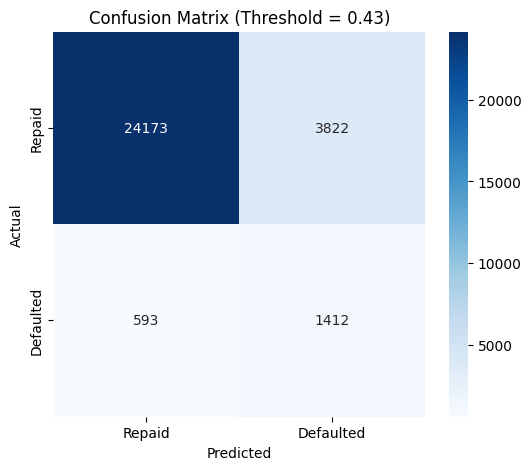

In [36]:
# Evaluation
model.eval()
y_val_probs = []

with torch.no_grad():
    for x_all, _ in val_loader:  
        x_all = x_all.to(device)
        outputs = model(x_all)
        probs = torch.sigmoid(outputs)
        y_val_probs.extend(probs.cpu().numpy())

y_val_probs = np.array(y_val_probs)
prec, rec, thresholds = precision_recall_curve(y_val, y_val_probs)
best_thresh_a = threshold_by_target_recall(y_val, y_val_probs, thresholds, 0.68)

y_test_probs = []
with torch.no_grad():
    for x_all, _ in test_loader:
        x_all = x_all.to(device)
        outputs = model(x_all)
        probs = torch.sigmoid(outputs)
        y_test_probs.extend(probs.cpu().numpy())

y_test_probs = np.array(y_test_probs)
y_test_pred_opt = (y_test_probs > best_thresh_a).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_test_pred_opt, target_names=target_names)
acc = accuracy_score(y_test, y_test_pred_opt)
roc_auc = roc_auc_score(y_test, y_test_probs)
cm = confusion_matrix(y_test, y_test_pred_opt)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print("Best threshold:", best_thresh_a)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh_a:.2f})")
plt.show()

In [29]:
param_dist = {
    "booster": ["gbtree"],                
    "learning_rate": [0.005, 0.008, 0.01], 
    "max_depth": [4, 6, 8],               
    "min_child_weight": [6, 10, 12],    
    "gamma": [0.0, 0.5, 1.0],              
    "subsample": [0.65, 0.75, 0.85],       
    "colsample_bytree": [0.65, 0.75, 0.85],
    "reg_alpha": [0, 2, 5, 8],          
    "reg_lambda": [2, 6, 10],        
}

n_iter = 4  
sampler = ParameterSampler(param_dist, n_iter=n_iter, random_state=42)

best_auc, best_params = 0.0, None

for i, params in enumerate(sampler, start=1):
    print(f"[INFO] Running model {i}/{len(sampler)} with params: {params}")

    model_b = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
        n_estimators=800,
        max_bin=1024,
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        device="cuda",
        early_stopping_rounds=100,
        **params
    )
    
    model_b.fit(
        X_train_xgb, y_train,
        eval_set=[(X_val_xgb, y_val)],
        verbose=False
    )
    
    if model_b.best_score > best_auc:
        best_auc, best_params = model_b.best_score, params

print("Best AUC:", best_auc)
print("Best params:", best_params)

[INFO] Running model 1/4 with params: {'subsample': 0.75, 'reg_lambda': 10, 'reg_alpha': 8, 'min_child_weight': 6, 'max_depth': 6, 'learning_rate': 0.008, 'gamma': 0.5, 'colsample_bytree': 0.85, 'booster': 'gbtree'}
[INFO] Running model 2/4 with params: {'subsample': 0.85, 'reg_lambda': 6, 'reg_alpha': 8, 'min_child_weight': 12, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 0.65, 'booster': 'gbtree'}
[INFO] Running model 3/4 with params: {'subsample': 0.85, 'reg_lambda': 10, 'reg_alpha': 5, 'min_child_weight': 12, 'max_depth': 6, 'learning_rate': 0.008, 'gamma': 1.0, 'colsample_bytree': 0.75, 'booster': 'gbtree'}
[INFO] Running model 4/4 with params: {'subsample': 0.75, 'reg_lambda': 10, 'reg_alpha': 0, 'min_child_weight': 6, 'max_depth': 4, 'learning_rate': 0.008, 'gamma': 1.0, 'colsample_bytree': 0.75, 'booster': 'gbtree'}
Best AUC: 0.8568097993925808
Best params: {'subsample': 0.85, 'reg_lambda': 10, 'reg_alpha': 5, 'min_child_weight': 12, 'max_depth': 6, 

Best threshold: 0.5806203484535217
              precision    recall  f1-score   support

      Repaid       0.98      0.87      0.92     27995
   Defaulted       0.27      0.70      0.39      2005

    accuracy                           0.85     30000
   macro avg       0.62      0.78      0.65     30000
weighted avg       0.93      0.85      0.88     30000

Accuracy: 85.50%
ROC AUC: 0.870
TP=1404, FP=3750, TN=24245, FN=601
Accuracy for class 'Repaid': 86.60%
Accuracy for class 'Defaulted': 70.02%


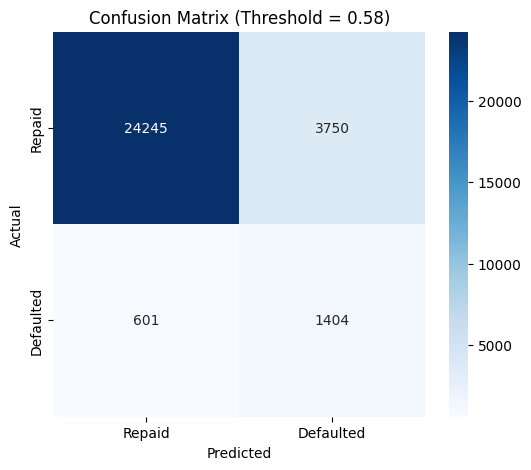

In [30]:
# Evaluation
dtest = xgb.DMatrix(X_test_xgb)
y_probs = model_b.get_booster().predict(dtest) 

# Target defaults recall
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
best_thresh_b = threshold_by_target_recall(y_test, y_probs, thresholds, 0.7)
y_pred = (y_probs > best_thresh_b).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_pred, target_names=target_names)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)
roc_auc = roc_auc_score(y_test, y_probs)

print("Best threshold:", best_thresh_b)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh_b:.2f})")
plt.show()

In [31]:
# Shap xgb
explainer = shap.TreeExplainer(model_b)
shap_values = explainer.shap_values(X_train_xgb)
mean_abs_shap = np.abs(shap_values).mean(axis=0)

importance_df = pd.DataFrame({
    "Feature": X_train_xgb.columns,
    "Importance": mean_abs_shap
}).sort_values("Importance", ascending=False).reset_index(drop=True)

print("SHAP Importance:")
print(importance_df)

SHAP Importance:
                                           Feature  Importance
0                      UtilizationBucketLateBucket    0.634613
1                DelinquencyScoreUtilizationPerAge    0.274991
2                                UtilizationPerAge    0.258773
3                                 DelinquencyScore    0.204071
4             DelinquencyScoreRevolvingUtilization    0.173931
5                              DebtToIncomeAgeRisk    0.128092
6                              IncomePerCreditLine    0.114830
7                      RevolvingUtilizationAgeRisk    0.102584
8                                MonthlyIncomeSafe    0.063630
9                         UtilizationPerCreditLine    0.053046
10                            RevolvingUtilization    0.052518
11                      IncomePerCreditLineAgeRisk    0.043104
12                              RealEstateLeverage    0.041947
13                       LatePaymentsPerCreditLine    0.040292
14                                    

In [32]:
# Shap NN
model_gpu = copy.deepcopy(model).to(device)
model_gpu.eval()

def shap_ohe_gpu(X):
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
    with torch.no_grad():
        logits = model_gpu(X_tensor)
        probs = torch.sigmoid(logits).cpu().numpy()
    return probs

feature_names = list(X_train_nn_full.columns)
background = shap.sample(X_train_tensor.cpu().numpy(), 100)
explainer = shap.KernelExplainer(shap_ohe_gpu, background)
shap_values = explainer.shap_values(X_val_tensor[:500].cpu().numpy())
shap_values_array = np.array(shap_values)
mean_abs_shap = np.abs(shap_values_array).mean(axis=0)

importance_df = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values(by="mean_abs_shap", ascending=False).reset_index(drop=True)

print("SHAP Importance:")
print(importance_df)

  0%|          | 0/500 [00:00<?, ?it/s]

SHAP Importance:
                                           feature  mean_abs_shap
0                                 DelinquencyScore       0.118827
1                                UtilizationPerAge       0.061117
2                UtilizationBucketLateBucket_Other       0.030138
3                             RevolvingUtilization       0.025905
4      UtilizationBucketLateBucket_Very Low_NoLate       0.024420
5                              DebtToIncomeAgeRisk       0.018473
6           UtilizationBucketLateBucket_Low_NoLate       0.016185
7                              IncomePerCreditLine       0.011127
8      UtilizationBucketLateBucket_Moderate_NoLate       0.007252
9                               RealEstateLeverage       0.006072
10                               MonthlyIncomeSafe       0.005451
11            WasIncomePerCreditLineAgeRiskImputed       0.004796
12           WasRevolvingUtilizationAgeRiskImputed       0.004767
13                                       DebtRatio       0.

In [37]:
# Save NN model
torch.save(model.state_dict(), "cr_weights.pth")

In [38]:
# Save xgb model
model_b.save_model("cr_b.json")

In [39]:
# Save for hosting
joblib.dump(X_train_xgb.columns.tolist(), "xgb_col_order.pkl")
joblib.dump(X_train_nn_full.columns.tolist(), "nn_col_order.pkl")
joblib.dump(best_thresh_a, "threshold_a.pkl")
joblib.dump(best_thresh_b, "threshold_b.pkl")
joblib.dump(num_imputer, "num_imputer.pkl")
joblib.dump(cat_imputer, "cat_imputer.pkl")
joblib.dump(robust_scaler, "robust_scaler.pkl")
joblib.dump(std_scaler, "std_scaler.pkl")
joblib.dump(num_col_order, "num_col_order.pkl")
joblib.dump(cat_maps, "cat_maps.pkl")
joblib.dump(cat_col_order, "cat_col_order.pkl")
joblib.dump(skewed_col_order, "skewed_col_order.pkl")
joblib.dump(rare_maps, "rare_maps.pkl")

['rare_maps.pkl']